# Gaussian Mixture Models (GMM)

In [100]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.mixture import GaussianMixture
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal
from itertools import chain
from matplotlib.patches import Ellipse

sns.set_context('notebook')
sns.set_style('white')

GMM are clustering models that fit weighted distributions of Gaussians to the training data. The main signifying feature is that GMM is a soft clustering model. Instead of assigning each datapoint to exactly one cluster, a weighted sum of different clusters is used.

A big advantage of this is that the result of a classification will also contain probabilities over multiple options. First of all, this gives the likelyhood of a datapoint beloning to a certain cluster, which is already useful when making more complex preditictions. But it also gives the option to return multiple clusters as output.

This last one is very useful in recommender systems, where multiple clusters can be relevant. For example, a user of a streaming service can belong both to the Comedy and the Horror cluster with different weight factors.

## Math

A Gaussian mixture of K gaussians is defined as

$$
p(\boldsymbol{x}) = \sum_{i=1}^K\pi_i \mathcal{N}(x|\boldsymbol{\mu_i,\Sigma_i}), \\\\\\ \sum_{i=1}^K\pi_i = 1
$$

Where 
1. mean ->  $\boldsymbol{\mu}_i$
2. covariance matrix -> $\boldsymbol{\Sigma}_i$
3. component weight -> $\pi_i$ that indicates the contribution of the $i\text{th}$ Gaussian

In [52]:
## HELPER FUNCTIONS

# This function will allow us to easily plot data taking in x values, y values, and a title
def plot_univariate_mixture(means, stds, weights, N = 10000, seed=10):
    
    """
    returns the simulated 1d dataset X, a figure, and the figure's ax
    
    """
    np.random.seed(seed)
    if not len(means)==len(stds)==len(weights):
        raise Exception("Length of mean, std, and weights don't match.") 
    K = len(means)
    
    mixture_idx = np.random.choice(K, size=N, replace=True, p=weights)
    # generate N possible values of the mixture
    X = np.fromiter((ss.norm.rvs(loc=means[i], scale=stds[i]) for i in mixture_idx), dtype=np.float64)
      
    # generate values on the x axis of the plot
    xs = np.linspace(X.min(), X.max(), 300)
    ps = np.zeros_like(xs)
    
    for mu, s, w in zip(means, stds, weights):
        ps += ss.norm.pdf(xs, loc=mu, scale=s) * w
    
    fig, ax = plt.subplots()
    ax.plot(xs, ps, label='pdf of the Gaussian mixture')
    ax.set_xlabel("X", fontsize=15)
    ax.set_ylabel("P", fontsize=15)
    ax.set_title("Univariate Gaussian mixture", fontsize=15)
    #plt.show()
    
    return X.reshape(-1,1), fig, ax
    
    
def plot_bivariate_mixture(means, covs, weights, N = 10000, seed=10):
    
    """
    returns the simulated 2d dataset X and a scatter plot is shown
    
    """
    np.random.seed(seed)
    if not len(means)==len(covs)==len(weights):
        raise Exception("Length of mean, std, and weights don't match.") 
    K = len(means)
    M = len(means[0])
    
    mixture_idx = np.random.choice(K, size=N, replace=True, p=weights)
    
    # generate N possible values of the mixture
    X = np.fromiter(chain.from_iterable(multivariate_normal.rvs(mean=means[i], cov=covs[i]) for i in mixture_idx), 
                dtype=float)
    X.shape = N, M
    
    xs1 = X[:,0] 
    xs2 = X[:,1]
    
    plt.scatter(xs1, xs2, label="data")
    
    L = len(means)
    for l, pair in enumerate(means):
        plt.scatter(pair[0], pair[1], color='red')
        if l == L-1:
            break
    plt.scatter(pair[0], pair[1], color='red', label="mean")
    
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.title("Scatter plot of the bivariate Gaussian mixture")
    plt.legend()
    plt.show()
    
    return X


def draw_ellipse(position, covariance, ax=None, **kwargs):
    
    """
    Draw an ellipse with a given position and covariance
    
    """
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle=angle, **kwargs))
        
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)


The helper functions defined above help to plot mixtures of gaussians for illustration purposes. First a mixture of 3 univariate gaussians is plotted. Then the gaussians are plotted with the same mean, but bigger standard-deviation. Finally the weight factors are adjusted. It is clear how these parameters affect the distribution.

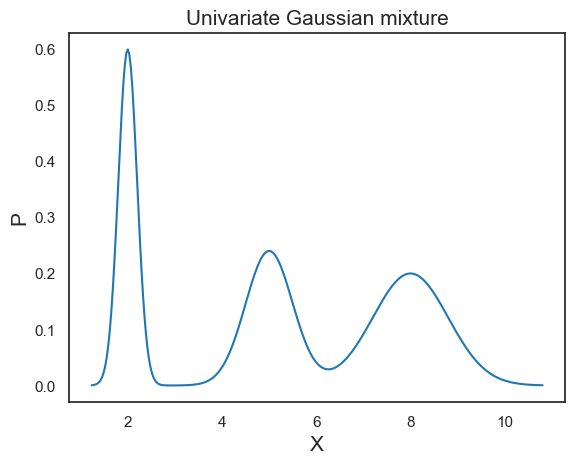

In [28]:
X1, fig1, ax1 = plot_univariate_mixture(means=[2,5,8], stds=[0.2, 0.5, 0.8], weights=[0.3, 0.3, 0.4]) 

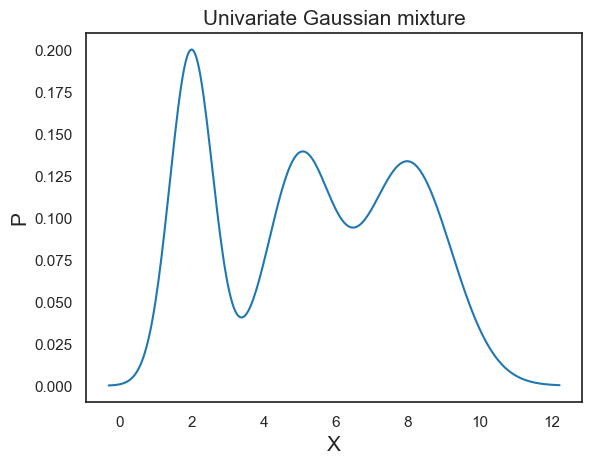

In [29]:
X2, fig2, ax2 = plot_univariate_mixture(means=[2,5,8], stds=[0.6, 0.9, 1.2], weights=[0.3, 0.3, 0.4]) 

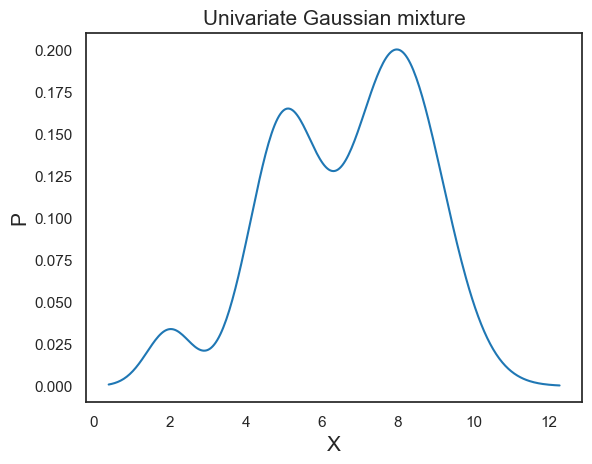

In [30]:
X3, fig3, ax3 = plot_univariate_mixture(means=[2,5,8], stds=[0.6, 0.9, 1.2], weights=[0.05, 0.35, 0.6]) 

## Sklearn GaussianMixture

Since we generated the data above, we know exactly what the parameter values were. But in a real case we wwouldn't have this ready. So luckily sklearn has the GaussianMixtures classifier which is capable of estimating parameters from a gaussian mixture.

For this we need to specify how many components (gaussians) there are (or we expect) in the input data.

The result of this is a probability probability for each of the clusters, how likely it is that the sample belongs to that cluster. 

Below, the black-colored point is the top (mean value) of the leftmost gaussian, obviously this point is classified to be 100% in the blue cluster and 0% in any of the other clusters.

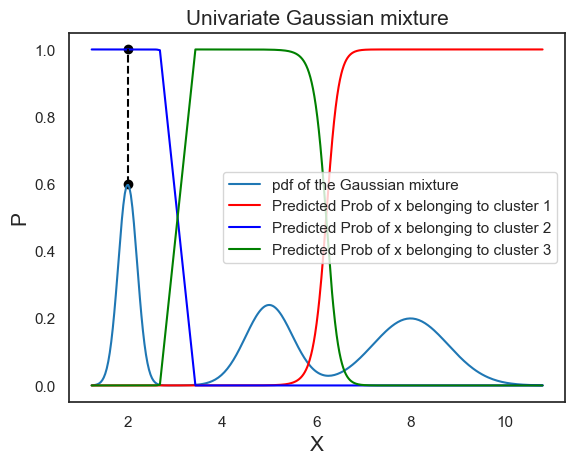

In [31]:
# sort X1 in ascending order for plotting purpose
X1_sorted = np.sort(X1.reshape(-1)).reshape(-1,1)

# fit the GMM
GMM = GaussianMixture(n_components=3, random_state=10)
GMM.fit(X1_sorted)

# store the predicted probabilities in prob_X1
prob_X1 = GMM.predict_proba(X1_sorted)

# start plotting! 
ax1.plot(X1_sorted, prob_X1[:,0], label='Predicted Prob of x belonging to cluster 1', color='red')
ax1.plot(X1_sorted, prob_X1[:,1], label='Predicted Prob of x belonging to cluster 2', color='blue')
ax1.plot(X1_sorted, prob_X1[:,2], label='Predicted Prob of x belonging to cluster 3', color='green')
ax1.scatter(2, 0.6, color='black')
ax1.scatter(2, 1.0, color='black')
ax1.plot([2, 2], [0.6, 1.0],'--', color='black')
ax1.legend()
fig1

## GMM on 2D data

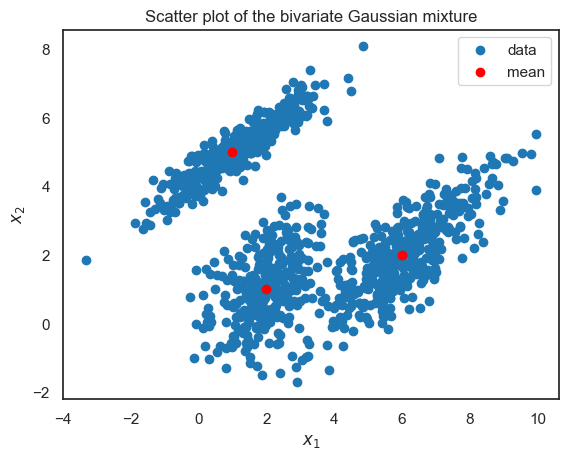

The dataset we generated has a shape of (1000, 2)


In [49]:
mean = [(1,5), (2,1), (6,2)]
cov1 = np.array([[1.5, 1.0],[1.0, 0.8]])
cov2 = np.array([[0.8, 0.4],[0.4, 1.2]])
cov3 = np.array([[1.7, 1.3],[1.3, 1.5]])
cov = [cov1, cov2, cov3]
weights = [0.3, 0.3, 0.4]

X4 = plot_bivariate_mixture(means=mean, covs=cov, weights=weights, N=1000)

print("The dataset we generated has a shape of", X4.shape)

Now we can fit a GMM on this distribution. We know that there are 3 Gaussians in the data, so picking K is easy.

In [50]:
gm = GaussianMixture(n_components=3, random_state=0).fit(X4)
print("Means of the 3 Gaussians fitted by GMM are\n")
print(gm.means_)

Means of the 3 Gaussians fitted by GMM are

[[1.06247691 5.03577306]
 [6.05625191 2.00376139]
 [1.95560723 1.08216242]]


The helper function defined above can help with plotting the clusters. Each cluster is assigned a different color, and ellipses are added that show the 1st and 2nd standard deviation from the mean.

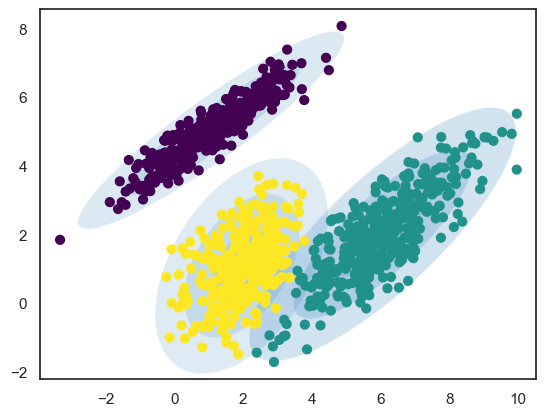

In [54]:
plot_gmm(gm, X4)

## Types of covariance

The Covariance matrix defines the shape of our gassians. So we can also let the model know what kind of covariance matrix we expect to find. For example:
- 'full', no restrictions on covariance, each component is handled individually.
- 'tied', the same covariance matrix for all components
- 'diag', each component has its own covariance matrix, but it must be diagonal (only pure x- and y-components)
- 'spherical', each component has only a single variance for both directions

By default the 'full' mode is used.

In the data above the 'full' mode is the correct choice. This is clear from the form of the input covariance matrices.

## GMM for image segmentation

GMM can also be sed for image segmentation, where we want to segment an image into K regions with probability of overlap.

In [62]:
from PIL import Image

im = Image.open("./data/gauss-cat.jpeg")
w, h = im.width, im.height
n = 3
im.size, im.mode

((1591, 1920), 'RGB')

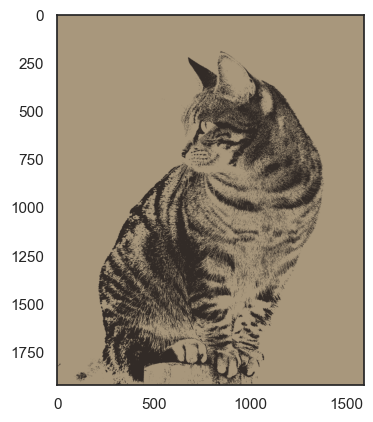

In [93]:
X = np.array(im).reshape(-1, 3)

K = 2

gmm = GaussianMixture(n_components=K, covariance_type='tied')
labels = gmm.fit_predict(X)
segmented_im = gmm.means_.astype(np.uint8)[labels].reshape((h, w, n))
plt.imshow(segmented_im);

Even though we only use 2 colors, the image is clearly recognisable. Let's add a few more clusters and see the result

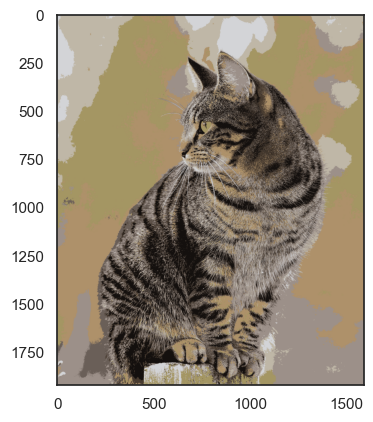

In [94]:
X = np.array(im).reshape(-1, 3)
K = 8
gmm = GaussianMixture(n_components=K, covariance_type='tied')
labels = gmm.fit_predict(X)
segmented_im = gmm.means_.astype(np.uint8)[labels].reshape((h, w, n))
plt.imshow(segmented_im);

That's really good, even though we only use 8 colors. Unfortunately, fitting the model is quite slow.

## GMM customers

For more examples of GMM, we use the Kaggle dataset for Customer Personality Analysis: [Kaggle - Omar Romero-Hernandez - Customer Personality](https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis).

We'll need to perform a bit of data wrangling before we can use it though.

The dataset has:
- 19 columns (18 int, 1 float)
- 2216 entries

In [95]:
df = pd.read_csv('./data/customers.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2216 entries, 0 to 2215
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2216 non-null   int64  
 1   Income               2216 non-null   float64
 2   Kidhome              2216 non-null   int64  
 3   Teenhome             2216 non-null   int64  
 4   Recency              2216 non-null   int64  
 5   Wines                2216 non-null   int64  
 6   Fruits               2216 non-null   int64  
 7   Meat                 2216 non-null   int64  
 8   Fish                 2216 non-null   int64  
 9   Sweets               2216 non-null   int64  
 10  Gold                 2216 non-null   int64  
 11  NumDealsPurchases    2216 non-null   int64  
 12  NumWebPurchases      2216 non-null   int64  
 13  NumCatalogPurchases  2216 non-null   int64  
 14  NumStorePurchases    2216 non-null   int64  
 15  NumWebVisitsMonth    2216 non-null   i

We'll need to scale the values as clustering algorithms can be very sensitive to feature scale.

In [98]:
df.describe().T.drop(columns=['count', '25%', '75%'])

,mean,std,min,50%,max
Education,0.611011,0.683469,0.0,0.0,2.0
Income,52247.251354,25173.076661,1730.0,51381.5,666666.0
Kidhome,0.441787,0.536896,0.0,0.0,2.0
Teenhome,0.505415,0.544181,0.0,0.0,2.0
Recency,49.012635,28.948352,0.0,49.0,99.0
Wines,305.091606,337.327920,0.0,174.5,1493.0
Fruits,26.356047,39.793917,0.0,8.0,199.0
Meat,166.995939,224.283273,0.0,68.0,1725.0
Fish,37.637635,54.752082,0.0,12.0,259.0
Sweets,27.028881,41.072046,0.0,8.0,262.0


In [99]:
ss = StandardScaler()
X = ss.fit_transform(df)

We'll also perform dimensionality reduction with PCA to 2 components. Otherwise the fitting

In [103]:
pca = PCA(n_components=2)
X_red = pca.fit_transform(X)

In [ ]:
model = GaussianMixture(n_components=4, random_state=0)
labels = model.fit_predict(X)

Text(0, 0.5, 'PCA 2')

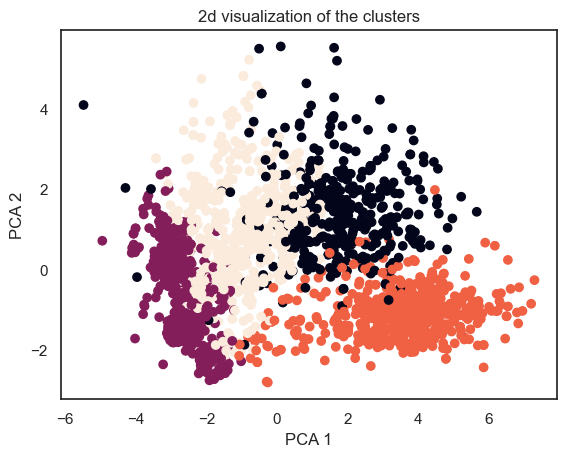

In [105]:
x = X_red[:, 0]
y = X_red[:, 1]
plt.scatter(x, y, c=labels)
plt.title("2d visualization of the clusters")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

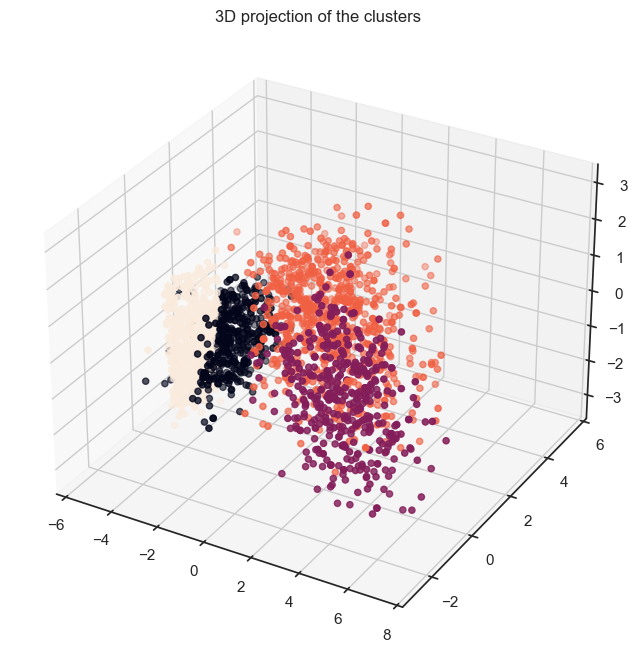

In [107]:
pca3 = PCA(n_components=3)
reduced_3_PCA = pca3.fit_transform(X)
mod = GaussianMixture(n_components=4, random_state=0)
PCA_3_pred = mod.fit_predict(reduced_3_PCA)

reduced_3_PCA = pd.DataFrame(reduced_3_PCA, columns=(['PCA 1', 'PCA 2', 'PCA 3']))
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(reduced_3_PCA['PCA 1'],reduced_3_PCA['PCA 2'],reduced_3_PCA['PCA 3'], c=PCA_3_pred)
ax.set_title("3D projection of the clusters");